In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # type: ignore
from tensorflow.keras.models import load_model # type: ignore
import tensorflow as tf
import pandas as pd
import json

# Local imports
from src.data_processing.lstm_data_preprocessing import reduce_time_bucket_features, FeaturesConfig, TimeBucketConfig
from src.data_processing.loader import load_time_bucket_data

2025-04-26 11:36:30.897062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745663790.911469   10009 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745663790.915679   10009 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745663790.928183   10009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745663790.928204   10009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745663790.928206   10009 computation_placer.cc:177] computation placer alr

In [3]:
# Load the model and details on configurations used to train the model like the time bucket data used and the features used

# Custom loss function
def weighted_mse_large_moves(y_true, y_pred):
    diff = y_true - y_pred
    weight = tf.math.square(y_true)
    return tf.reduce_mean(weight * tf.square(diff))

model_folder = "../model_generation/trained_models/lstm_11"
model = load_model(os.path.join(model_folder, "model.keras"),
    custom_objects={'weighted_mse_large_moves': weighted_mse_large_moves})
with open(os.path.join(model_folder, "config.json"), 'r') as f:
    configs = json.load(f)

features_config = FeaturesConfig(**configs["features_config"])
time_bucket_folder = configs["time_bucket_folder"]
test_size = configs["test_size"]

I0000 00:00:1745663792.768954   10009 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5367 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:08:00.0, compute capability: 8.9


In [4]:
# Get the train test data set used to train the model were testing

X_scaler = StandardScaler()
y_scaler = StandardScaler()

token_time_buckets, time_bucket_config = load_time_bucket_data(time_bucket_folder)

token_datasets = []
for token_address, data in token_time_buckets.items():
    X = data["X"]
    y = data["y"]
    bucket_times = data["bucket_times"]

    # Only get the features listed in features_config
    X = reduce_time_bucket_features(X, features_config)

    token_datasets.append((X, y, token_address, bucket_times))

# Combine all token data
all_X = np.vstack([data[0] for data in token_datasets])
all_y = np.vstack([data[1].reshape(-1, 1) for data in token_datasets])

# Scale features
num_samples, time_steps, features = all_X.shape
X_reshaped = all_X.reshape(num_samples * time_steps, features)
X_scaled = X_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, time_steps, features)

# Scale target variable also using StandardScaler to preserve direction
y_scaled = y_scaler.fit_transform(all_y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, shuffle=False)

In [5]:
y_pred = model.predict(X_test)

# Inverse transform to get real values
y_pred_actual = y_scaler.inverse_transform(y_pred)
y_test_actual = y_scaler.inverse_transform(y_test)

I0000 00:00:1745663812.983848   10107 cuda_dnn.cc:529] Loaded cuDNN version 90300


523/523 ━━━━━━━━━━━━━━━━━━━━ 133s 253ms/step


In [6]:
from visualisation_methods import plot_error_distribution, plot_directional_accuracy, plot_prediction_vs_actual, plot_magnitude_accuracy, plot_value_distributions

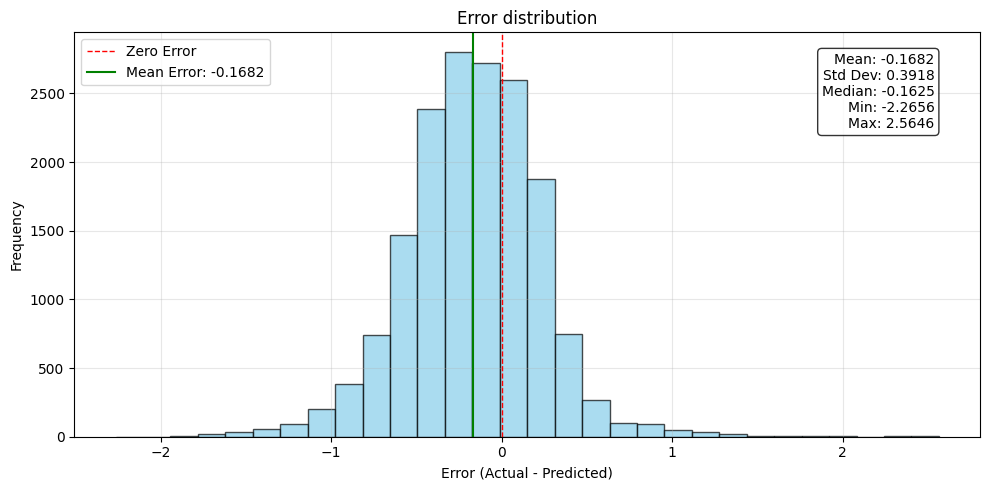

In [7]:
plot_error_distribution(y_pred_actual, y_test_actual, title="Error distribution")

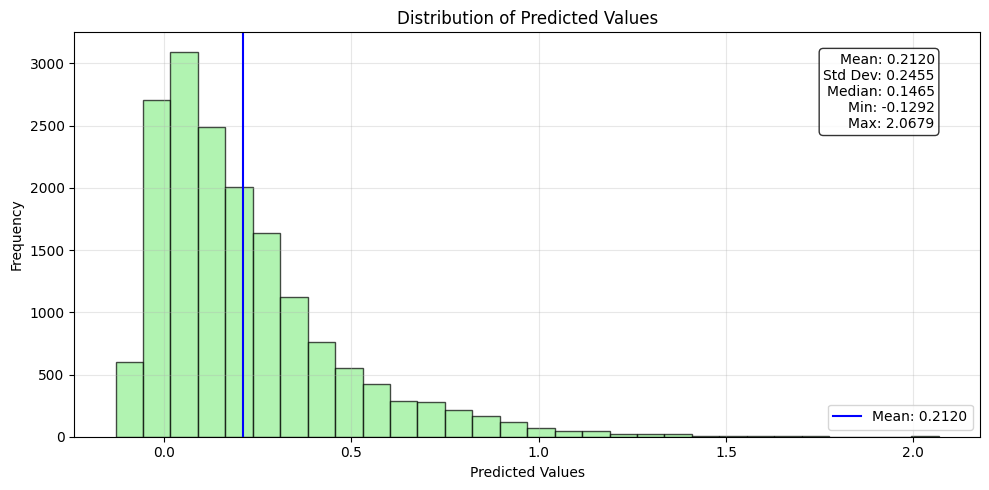

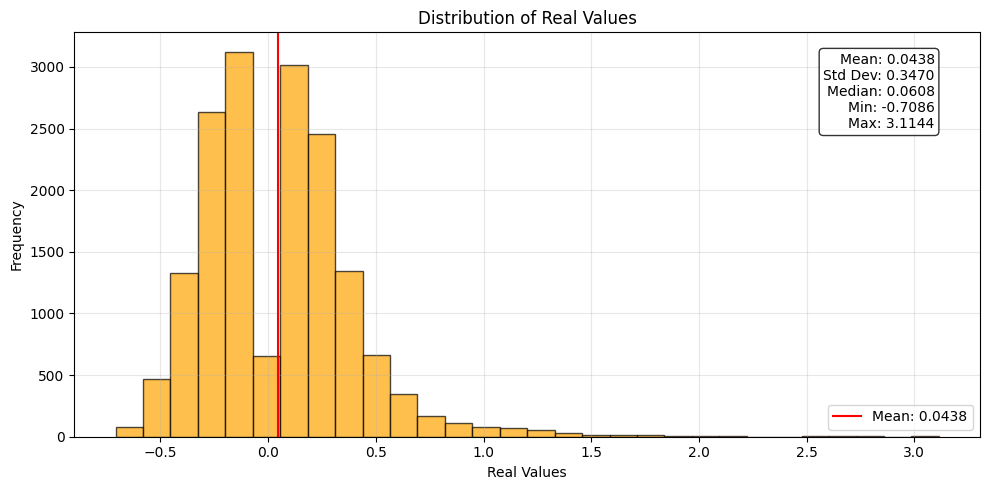

In [8]:
plot_value_distributions(y_pred_actual, y_test_actual)

In [9]:
print(max(y_pred_actual))

[2.067898]


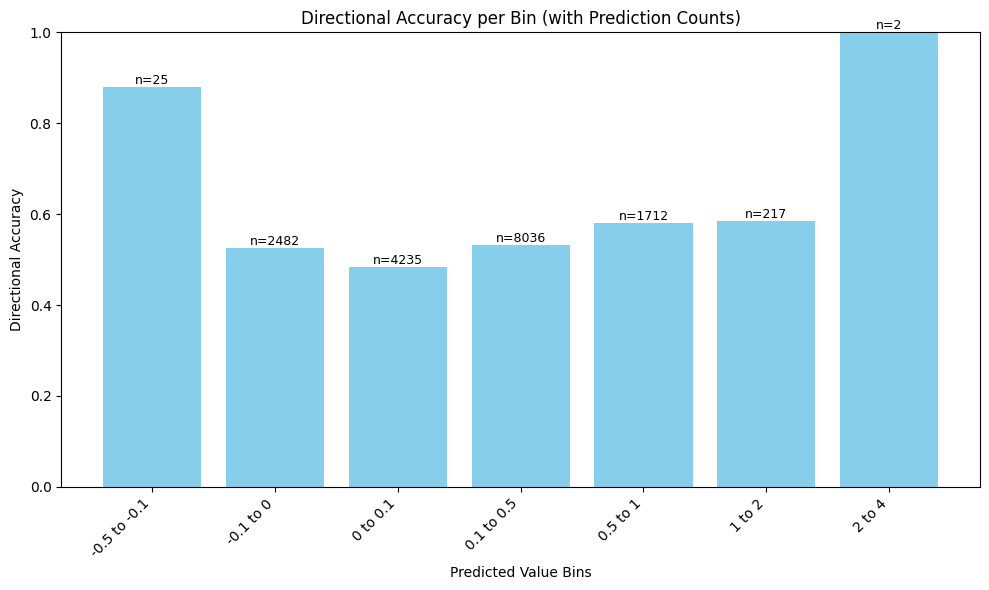

({'-0.5 to -0.1': np.float64(0.88),
  '-0.1 to 0': np.float64(0.5257856567284448),
  '0 to 0.1': np.float64(0.4833530106257379),
  '0.1 to 0.5': np.float64(0.5323544051767048),
  '0.5 to 1': np.float64(0.5811915887850467),
  '1 to 2': np.float64(0.5852534562211982),
  '2 to 4': np.float64(1.0)},
 {'-0.5 to -0.1': np.int64(25),
  '-0.1 to 0': np.int64(2482),
  '0 to 0.1': np.int64(4235),
  '0.1 to 0.5': np.int64(8036),
  '0.5 to 1': np.int64(1712),
  '1 to 2': np.int64(217),
  '2 to 4': np.int64(2)})

In [10]:
bins = [-np.inf, -8, -4, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 4, 8, np.inf]
plot_directional_accuracy(y_pred_actual, y_test_actual, bins=bins)

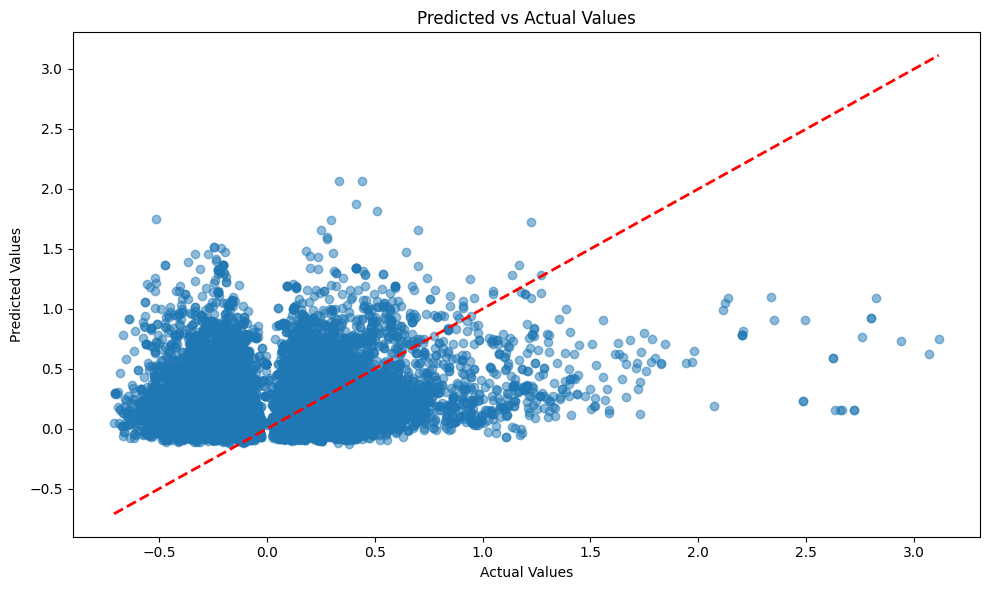

In [11]:
plot_prediction_vs_actual(y_pred_actual, y_test_actual)

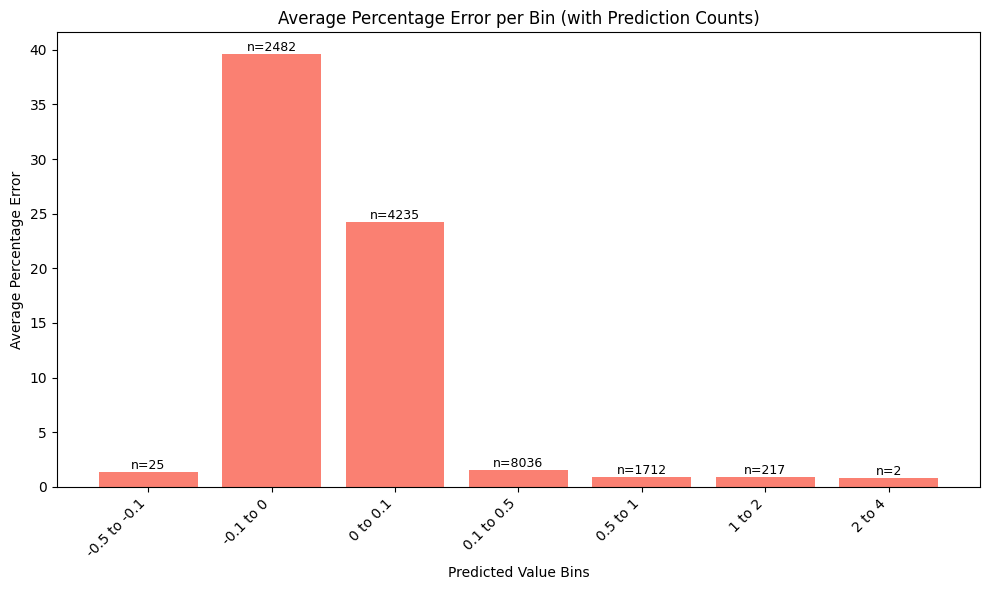

({'-0.5 to -0.1': np.float64(1.319395365688179),
  '-0.1 to 0': np.float64(39.61196366952563),
  '0 to 0.1': np.float64(24.22333433441365),
  '0.1 to 0.5': np.float64(1.5190398608228195),
  '0.5 to 1': np.float64(0.9303321717119102),
  '1 to 2': np.float64(0.8733590943292249),
  '2 to 4': np.float64(0.8120076128184064)},
 {'-0.5 to -0.1': np.int64(25),
  '-0.1 to 0': np.int64(2482),
  '0 to 0.1': np.int64(4235),
  '0.1 to 0.5': np.int64(8036),
  '0.5 to 1': np.int64(1712),
  '1 to 2': np.int64(217),
  '2 to 4': np.int64(2)})

In [12]:
plot_magnitude_accuracy(y_pred_actual, y_test_actual, bins=bins, use_percentage_error=True)

In [13]:
def get_test_tokens_with_large_pred(token_datasets, test_size, y_pred_actual, min_abs_pred_size=1.5):
    total_buckets = sum(len(data[1]) for data in token_datasets)
    test_start_idx = int((1 - test_size) * total_buckets)

    fully_test_tokens = {}
    current_idx = 0
    y_pred_test_index = 0  # Index within y_pred_actual

    for X, y, token_address, bucket_times in token_datasets:
        token_len = len(y)
        token_start_idx = current_idx
        current_idx += token_len

        # Only process tokens fully in the test set
        if token_start_idx >= test_start_idx:
            bucket_pred_map = []

            for i in range(token_len):
                if y_pred_test_index >= len(y_pred_actual):
                    break  # Prevent overflow if mismatch in lengths
                pred = y_pred_actual[y_pred_test_index].item()
                if abs(pred) >= min_abs_pred_size:
                    bucket_pred_map.append({
                        'bucket_time': tuple(bucket_times[i]),
                        'prediction': pred
                    })
                y_pred_test_index += 1

            if bucket_pred_map:
                fully_test_tokens[token_address] = bucket_pred_map

    return fully_test_tokens


In [14]:
# Set minimum absolute prediction size
min_abs_pred_size = 1

# Get tokens with large predictions
test_tokens_pred = get_test_tokens_with_large_pred(token_datasets, test_size, y_pred_actual, min_abs_pred_size=min_abs_pred_size)

# Print the results
print(list(test_tokens_pred.keys()))  # Print token addresses
print(len(test_tokens_pred))  # Print number of tokens

['BcqwX6PMmeD8TCFPaQ1BApBjydEjHLEeixT1f4hwpump', '88ECh6Z8UQr4pxHVeDnoqsU1LgyRX8DYNVYVKDKypump', '8AAXv9QyUHxD9cc8dLmxEvkM17oyQhpV63HqsnKbpump', 'JBdzedNacqvovbegqhGeLk2nx3JxyxZUMyaDu7vFpump', '6oCkSNk5ZzAj6jdcqLsaccSgANepKAjebKKPZGYKpump', '5jXt1S2ovJGHoqGsptTrdkFFsjwG4tUgcaynwQxgpump', 'Dsyq16dhv3RZD7Q7czjtiM3DqzxZvnHNijrXL5X5pump', '31nmoKh9Jqg5Yp51GbTC6N4BRkt7NFVNW7U5xqTwAtdY', 'A66JfVU6iSMwfdNuTPCNHKiKvfsP6arafqVGiXrapump', 'FAk8a1PRJe3egnS5ETXZnuhZS2N13NgWxYANASy2pump', 'Eb5RkNxk69eZ37EPCzq4JzXhkYT99UGSuoqv3wQQpump', '5KC2xeJe6zWto676atVMWtn6imfWaZvoSceLXauWpump', '5wbsQ6KUFn7fmaQWLy9kRaf1TKAPLknXYhbPYnKypump', 'AqKNLFmiVYuEtr38VGNoaDiYUXK5s6FK2yUaPiz1pump', '5m3J4FhKed1piiVDxseQv5daYJT4vdaDxUvRbL6pvSKJ', '5Fv4AcPjssQPpodDic9VBiu43NtzyrXPszByVmBbpump', 'C2pm9rgDskSchUgP5QRaEsKvwDQhzaKscsithGsupump', '5RS3mdLQZqYZzsfvuKRitCm4BruQwGK2s1tAsPqJAzJH', '59rCeFjcSMkwRZfMNYJ1EnPN5s3wEXJHxZoQwKFR983D', '6ZHhwWxUhT8AqzxKfF613NNr4A2aVygi2epsBBKrKz27', 'AS9L9SmrxUYv8pCuZ1gX8SUvpAk9RWtMZGNqAP

In [15]:
from visualisation_methods import plot_predictions_on_price_graph
token_address = "bpR2DF4sMarWvMJT6tevpQ9K7AtXskBQ6zA35iCpump"
bucket_pred_map = test_tokens_pred[token_address]
plot_predictions_on_price_graph(token_address, bucket_pred_map, min_abs_pred_size=min_abs_pred_size)



KeyError: 'bpR2DF4sMarWvMJT6tevpQ9K7AtXskBQ6zA35iCpump'

In [ ]:
min_abs_pred_size = 3
test_tokens_real = get_test_tokens_with_large_pred(token_datasets, test_size, y_test_actual, min_abs_pred_size=min_abs_pred_size)
print(list(test_tokens_real.keys()))
print(len(test_tokens_real))

In [ ]:
token_address = "E5YYfMPBbWz3vvaQcdPfNSC659nBmMZFqpAXqPtcpump"
bucket_pred_map = test_tokens_real[token_address]
plot_predictions_on_price_graph(token_address, bucket_pred_map, min_abs_pred_size=min_abs_pred_size)

In [ ]:
from src.data_processing.loader import load_token_price_data

# Get all 1.75x predictions and their tokens
test_tokens_pred = get_test_tokens_with_large_pred(token_datasets, test_size, y_pred_actual, min_abs_pred_size=1.5)

# Load price data
tokens_tx_data = {
    token: load_token_price_data(token, use_datetime=False)
    for token in test_tokens_pred.keys()
}

buy_size = 0.1  # Fixed investment in SOL

# Strategy parameters
sell_targets = [1.0, 1.5, 2.5, 5]                # Profit target percentages (e.g., +100%, +150%)
trailing_stop_targets = [0.5, 0.75]       # Trailing drawdown levels (e.g., -10%, -20%)
buy_fee_pct = 0.01
sell_fee_pct = 0.01
slippage_pct = 0.005

# Stats
total_profit = 0
num_trades = 0
num_wins = 0
num_losses = 0
profits = []

for token_address, bucket_pred_map in test_tokens_pred.items():
    price_df = tokens_tx_data[token_address]
    price_df = price_df.groupby(price_df.index).mean().sort_index()

    print(f"\nSimulating for token: {token_address}")
    executed_trade = False

    for pred_data in bucket_pred_map:
        if executed_trade:
            break

        bucket_time = pred_data['bucket_time']
        pred = pred_data['prediction']
        if pred < 0 :
            continue
        start_time, end_time = bucket_time

        if end_time not in price_df.index:
            closest_idx = price_df.index.get_indexer([end_time], method='nearest')[0]
            closest_time = price_df.index[closest_idx]
        else:
            closest_time = end_time

        raw_buy_price = price_df.loc[closest_time, 'price']
        if pd.isna(raw_buy_price):
            continue

        buy_price = raw_buy_price * (1 + slippage_pct)
        entry_value = buy_size * (1 - buy_fee_pct)
        tokens_bought = entry_value / buy_price
        remaining_tokens = tokens_bought
        profit = -buy_size
        peak_price = buy_price

        print(f"  Prediction: {pred}x | Buy Price: {buy_price} (with slippage/fees)")

        future_prices = price_df.loc[closest_time:]
        if len(future_prices) < 2:
            continue

        target_idx = 0
        stop_idx = 0

        for time, row in future_prices.iterrows():
            raw_price = row['price']
            peak_price = max(peak_price, raw_price)

            sell_price = raw_price * (1 - slippage_pct) * (1 - sell_fee_pct)

            # Profit targets
            if target_idx < len(sell_targets) and raw_price >= buy_price * (1 + sell_targets[target_idx]):
                sell_amount = remaining_tokens * 0.5
                profit += sell_amount * sell_price
                remaining_tokens -= sell_amount
                print(f"    Sold 50% at profit target {sell_targets[target_idx]}x | Price: {raw_price}")
                target_idx += 1

            # Trailing stop stages
            drawdown = 1 - (raw_price / peak_price)
            if stop_idx < len(trailing_stop_targets) and drawdown >= trailing_stop_targets[stop_idx]:
                sell_amount = remaining_tokens * 0.5
                profit += sell_amount * sell_price
                remaining_tokens -= sell_amount
                print(f"    Sold 50% at trailing stop {int(trailing_stop_targets[stop_idx]*100)}% | Price: {raw_price}")
                stop_idx += 1

            # Fully exit if no tokens left
            if remaining_tokens <= 0:
                print(f"    Fully exited. Total profit: {profit} SOL")
                break

        # If tokens remain, sell at final price
        if remaining_tokens > 0:
            final_price = raw_price * (1 - slippage_pct) * (1 - sell_fee_pct)
            profit += remaining_tokens * final_price
            print(f"    Final exit at {raw_price:.4f}. Total profit: {profit} SOL")

        # Update stats
        executed_trade = True
        num_trades += 1
        total_profit += profit
        profits.append(profit)
        if profit > 0:
            num_wins += 1
        else:
            num_losses += 1

# Summary
print("\n--- Strategy Summary ---")
print(f"Total Trades: {num_trades}")
print(f"Wins: {num_wins} | Losses: {num_losses}")
print(f"Win Rate: {(num_wins / num_trades * 100):.2f}%" if num_trades > 0 else "No trades made")
print(f"Total Profit: {total_profit:.4f} SOL")
if num_trades > 0:
    print(f"Average Profit per Trade: {(total_profit / num_trades):.4f} SOL")
